In [1]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? 
Nothing done.


In [1]:
import netCDF4 as nc
import pickle as pk
import numpy as np
import matplotlib.pyplot as plt

# Import grid data

In [2]:
# load depth at each NWA grid point
with open('pkvars/romsdepth.p', 'rb') as f:
    depth = pk.load(f)
    
# index BC depths
depth_east = depth[:, 721, :]
depth_south = depth[0, :, :]

# transpose depth to match other variable dims
depth_south=np.transpose(depth_south)
depth_east=np.transpose(depth_east)

In [3]:
# get latitude and longitude coordinates from NWA grid file
grd_file = "/d1/enrique/input/NWA_grd.nc"
grdds = nc.Dataset(grd_file, 'r')

lat = grdds.variables['lat_rho'][:]
lon = grdds.variables['lon_rho'][:]

# index BC coords
lat_south = lat[0, :]
lon_south = lon[0, :]

lat_east = lat[:, 721]
lon_east = lon[:, 721]

# repeat lat and lon at all 40 depth levels
lon_south = np.tile(lon_south, (40, 1))
lat_south = np.tile(lat_south, (40, 1))

lon_east = np.tile(lon_east, (40, 1))
lat_east = np.tile(lat_east, (40, 1))

# Import physical BC data

In [4]:
# load SODA NWA boundary condition file
SODA_file = "/d1/enrique/bdry/NWA_bdry_SODA3.3.1_y2012.nc"

# open read-only
Sds = nc.Dataset(SODA_file, 'r')

In [5]:
# pull out salinity and temperature 

temp_south = Sds.variables['temp_south'][:]
temp_east = Sds.variables['temp_east'][:]

salt_south = Sds.variables['salt_south'][:]
salt_east = Sds.variables['salt_east'][:]

# Convert Potential to Absolute temperature

In [6]:
def convert_potential_to_absolute(lat, lon, depth, salt, temp):
    # calcultes absolute temperature using gsw toolbox    
    import gsw
    
    SA = gsw.SA_from_SP(salt, depth, lon, lat)
    CT = gsw.CT_from_pt(SA, temp)
    ist = gsw.t_from_CT(SA, CT, depth)
    
    return ist

In [7]:
# convert conservative to in-situ temperature
ist_south = convert_potential_to_absolute(lat_south, lon_south, depth_south, salt_south, temp_south)
ist_east = convert_potential_to_absolute(lat_east, lon_east, depth_east, salt_east, temp_east)

ist_south.shape
#ist_east.shape

(73, 40, 722)

# Import bio BC data

In [8]:
# load bio NWA boundary condition file
bio_file = "/d1/enrique/bdry/NWA_bdry_bio.nc"
biods = nc.Dataset(bio_file, 'r')

In [9]:
# pull out oxygen and nitrate
o2_south = biods.variables['o2_south'][:]
o2_east = biods.variables['o2_east'][:]

no3_south = biods.variables['no3_south'][:]
no3_east = biods.variables['no3_east'][:]

# convert to umol/kg
o2_south = o2_south*10**6
o2_east = o2_east*10**6

no3_south = no3_south*10**6
no3_east = no3_east*10**6

In [21]:
# bio BCs are monthly and physical BCs are 5 day
# temporary fix: repeat bio time steps 5 times
# might be better to instead make bio BCs monthly 

# add bio vars, will add carbon
newfile = "NWA_bdry_MLR.nc" # copy of SODA_file
newds = nc.Dataset(newfile, 'a')

newds.createVariable('o2_south', 'f8', ('ocean_time', 's_rho', 'xi_rho'), fill_value=-10000000000.0)
newds.variables['o2_south'].long_name = 'Oxygen south boundary condition'
newds.variables['o2_south'].units = 'mol/kg'
newds.variables['o2_south'].field = 'o2_south, scalar, series'

newds.createVariable('o2_east', 'f8', ('ocean_time', 's_rho', 'eta_rho'), fill_value=-10000000000.0)
newds.variables['o2_east'].long_name = 'Oxygen east boundary condition'
newds.variables['o2_east'].units = 'mol/kg'
newds.variables['o2_east'].field = 'o2_east, scalar, series'

newds.createVariable('no3_south', 'f8', ('ocean_time', 's_rho', 'xi_rho'), fill_value=-10000000000.0)
newds.variables['no3_south'].long_name = 'Nitrate south boundary condition'
newds.variables['no3_south'].units = 'mol/kg'
newds.variables['no3_south'].field = 'no3_south, scalar, series'

newds.createVariable('no3_east', 'f8', ('ocean_time', 's_rho', 'eta_rho'), fill_value=-10000000000.0)
newds.variables['no3_east'].long_name = 'Nitrate east boundary condition'
newds.variables['no3_east'].units = 'mol/kg'
newds.variables['no3_east'].field = 'no3_east, scalar, series'

In [22]:
# copy steps for now to match dimensions

def write_bio_BC(varname):
    for timestep in range(12):
        varvals=biods.variables[varname][:]
        step = varvals[timestep:(timestep+1),:,:]
        rep = np.tile(step,(6,1,1))
        
        newds.variables[varname][(timestep*6):(timestep+1)*6]=rep    
        
write_bio_BC("o2_south")
write_bio_BC("no3_south")
write_bio_BC("o2_east")
write_bio_BC("no3_east")

#newds.variables.keys()

In [37]:
# use new oxygen and nitrate as inputs 
# pull out oxygen and nitrate

o2_south = newds.variables['o2_south'][:]
o2_east = newds.variables['o2_east'][:]

no3_south = newds.variables['no3_south'][:]
no3_east = newds.variables['no3_east'][:]

# Normalize variables for MLR

In [38]:
def normalize_MLR_inputs(ist, salt, oxygen, nitrate):
    # use mean and standard deviation of calibration data from McGarry et al., 2021
    # inputs are in situ temperature, practical salinity, oxygen and nitrate in umol/kg

    # temperature
    Tmean = 13.1856
    Tstd = 5.1979
    Tn = (ist-Tmean)/Tstd

    # salinity
    Smean = 34.4037
    Sstd = 1.4914
    Sn = (salt-Smean)/Sstd

    # oxygen
    Omean = 214.7
    Ostd = 44.7
    On = (oxygen-Omean)/Ostd

    #nitrate
    Nmean = 7.58
    Nstd = 7.65
    Nn = (nitrate-Nmean)/Nstd

    return Tn, Sn, On, Nn

In [39]:
Tn_south, Sn_south, On_south, Nn_south = normalize_MLR_inputs(ist_south, salt_south, o2_south, no3_south)
Tn_east, Sn_east, On_east, Nn_east = normalize_MLR_inputs(ist_east, salt_east, o2_east, no3_east)

# Apply MLRs

In [40]:
def apply_physical_MLR(Tn, Sn):
    # apply MLR equations to generate DIC in umol/kg and TA in ueq/kg
    
    # DIC coefficients
    a0=2103.3
    a1=-56.408
    a2=58.347
    a3=-7.2612

    # TA coeffficients
    b0=2289.4;
    b1=0.75761;
    b2=69.15;
    
    # MLR equations
    DIC_phys = a0 + a1*Tn + a2*Sn + a3*Tn*Sn
    TA_phys = b0 + b1*Tn + b2*Sn
    
    return DIC_phys, TA_phys

In [41]:
DIC_phys_south, TA_phys_south = apply_physical_MLR(Tn_south, Sn_south)
DIC_phys_east, TA_phys_east = apply_physical_MLR(Tn_east, Sn_east)

In [42]:
def apply_BGC_MLR(Tn, Sn, On):
    # apply MLR equations to generate DIC in umol/kg and TA in ueq/kg
    
    # DIC coefficients
    a0 = 2099
    a1 = -52.4
    a2 = 34.7
    a3 = -29.7
    a4 = -3.29
    
    # TA coefficients
    b0 = 2289
    b1 = 71.2
    b2 = 2.39

    # MLR equations
    DIC_BGC = a0 + a1*Tn + a2*Sn + a3*On + a4*Tn*Sn
    TA_BGC = b0 + b1*Sn + b2*On
    
    return DIC_BGC, TA_BGC

In [43]:
DIC_BGC_south, TA_BGC_south = apply_BGC_MLR(Tn_south, Sn_south, On_south)
DIC_BGC_east, TA_BGC_east = apply_BGC_MLR(Tn_east, Sn_east, On_east)

In [50]:
def apply_BGCp_MLR(Tn, Sn, On, Nn):
    # apply MLR equations to generate DIC in umol/kg and TA in ueq/kg
    
    # DIC coefficients
    a0 = 2101
    a1 = -51.4
    a2 = 31.3
    a3 = -2.26
    a4 = 1.71
    a5 = -2.26
    a6 = -3.88
    a7 = -6.15
    
    # TA coefficients
    # note! same as BGC, doesn't use nitrate
    b0 = 2289
    b1 = 71.2
    b2 = 2.39
    
    DIC_BGCp = a0 + a1*Tn + a2*Sn + a3*On + a4*Nn + a5*Tn*Sn + a6*Tn*On + a7*Sn*Nn
    TA_BGCp = b0 + b1*Sn + b2*On
    
    return DIC_BGCp, TA_BGCp
    

In [51]:
DIC_BGCp_south, TA_BGCp_south = apply_BGCp_MLR(Tn_south, Sn_south, On_south, Nn_south)
DIC_BGCp_east, TA_BGCp_east = apply_BGCp_MLR(Tn_east, Sn_east, On_east, Nn_east)

# Plot MLR-generated BCs to check

Text(0.5, 1.0, 'DIC south BGC+ (umol/kg)')

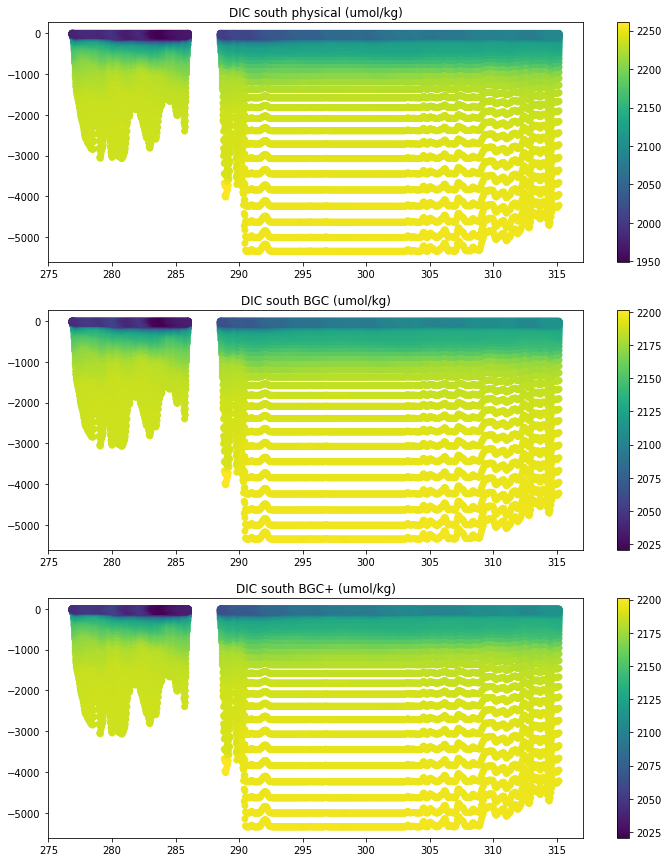

In [57]:
# plot DIC

plotstep = 0

fig = plt.figure(figsize=(12,15))

ax = fig.add_subplot(311)
plt.scatter(lon_south, depth_south, marker='o', c=DIC_phys_south[plotstep,:,:])
plt.colorbar()
plt.title("DIC south physical (umol/kg)")

ax = fig.add_subplot(312)
plt.scatter(lon_south, depth_south, marker='o', c=DIC_BGC_south[plotstep,:,:])
plt.colorbar()
plt.title("DIC south BGC (umol/kg)")

ax = fig.add_subplot(313)
plt.scatter(lon_south, depth_south, marker='o', c=DIC_BGCp_south[plotstep,:,:])
plt.colorbar()
plt.title("DIC south BGC+ (umol/kg)")

Text(0.5, 1.0, 'DIC east BGC+ (umol/kg)')

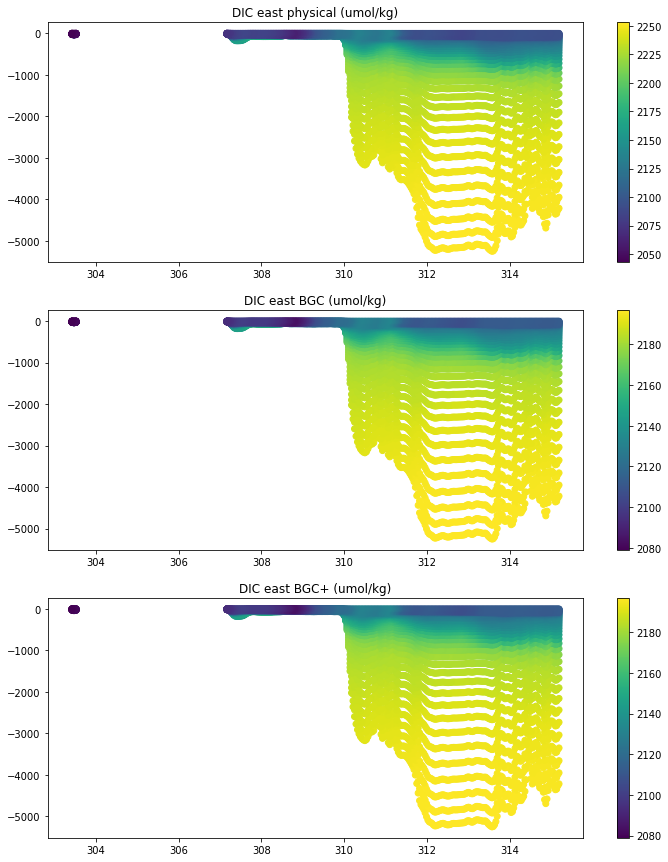

In [60]:
# plot DIC

plotstep = 70

fig = plt.figure(figsize=(12,15))

ax = fig.add_subplot(311)
plt.scatter(lon_east, depth_east, marker='o', c=DIC_phys_east[plotstep,:,:])
plt.colorbar()
plt.title("DIC east physical (umol/kg)")

ax = fig.add_subplot(312)
plt.scatter(lon_east, depth_east, marker='o', c=DIC_BGC_east[plotstep,:,:])
plt.colorbar()
plt.title("DIC east BGC (umol/kg)")

ax = fig.add_subplot(313)
plt.scatter(lon_east, depth_east, marker='o', c=DIC_BGCp_east[plotstep,:,:])
plt.colorbar()
plt.title("DIC east BGC+ (umol/kg)")

Text(0.5, 1.0, 'TA south BGC+ (umol/kg)')

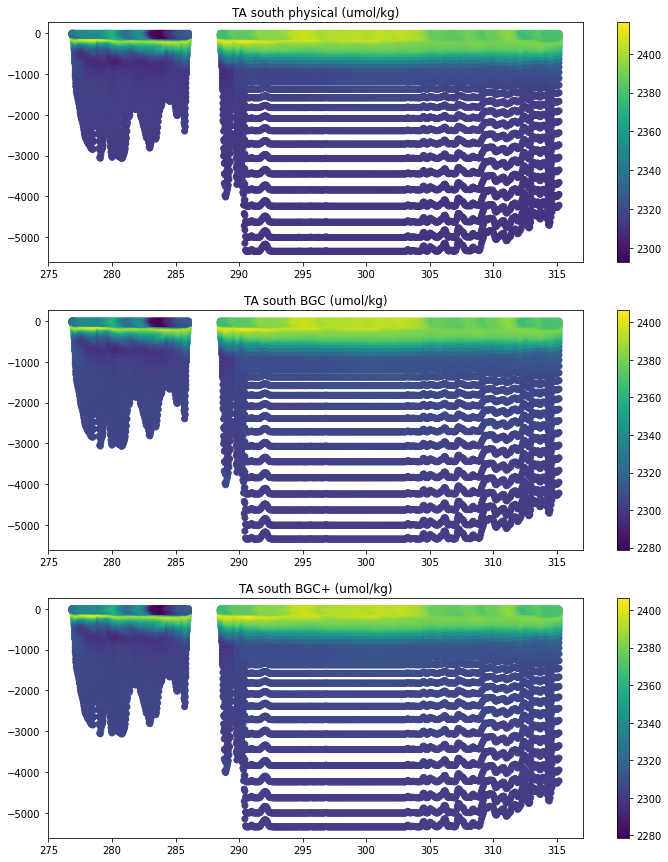

In [61]:
# plot TA

plotstep = 0

fig = plt.figure(figsize=(12,15))

ax = fig.add_subplot(311)
plt.scatter(lon_south, depth_south, marker='o', c=TA_phys_south[plotstep,:,:])
plt.colorbar()
plt.title("TA south physical (umol/kg)")

ax = fig.add_subplot(312)
plt.scatter(lon_south, depth_south, marker='o', c=TA_BGC_south[plotstep,:,:])
plt.colorbar()
plt.title("TA south BGC (umol/kg)")

ax = fig.add_subplot(313)
plt.scatter(lon_south, depth_south, marker='o', c=TA_BGCp_south[plotstep,:,:])
plt.colorbar()
plt.title("TA south BGC+ (umol/kg)")

Text(0.5, 1.0, 'TA east BGC+ (umol/kg)')

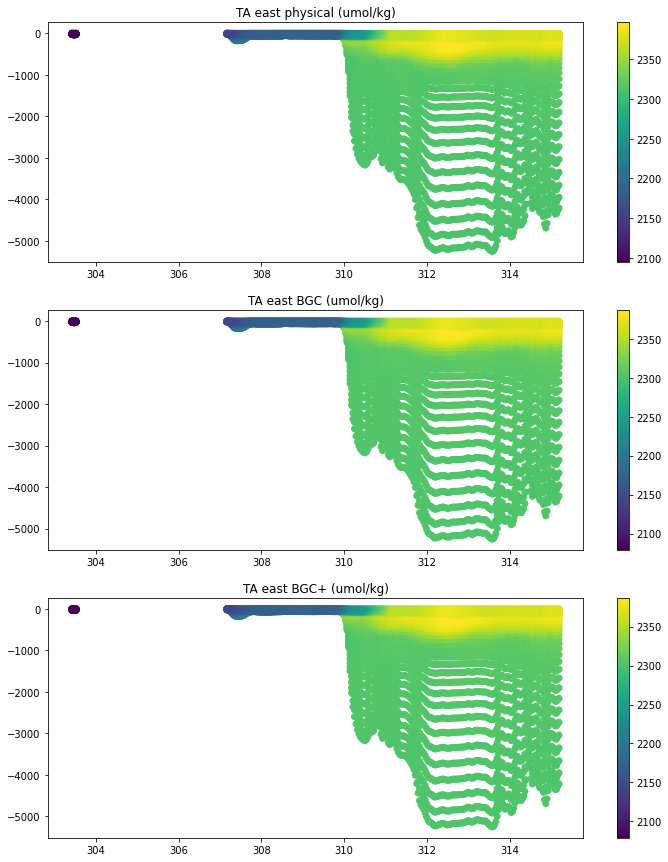

In [62]:
# plot TA

plotstep = 0

fig = plt.figure(figsize=(12,15))

ax = fig.add_subplot(311)
plt.scatter(lon_east, depth_east, marker='o', c=TA_phys_east[plotstep,:,:])
plt.colorbar()
plt.title("TA east physical (umol/kg)")

ax = fig.add_subplot(312)
plt.scatter(lon_east, depth_east, marker='o', c=TA_BGC_east[plotstep,:,:])
plt.colorbar()
plt.title("TA east BGC (umol/kg)")

ax = fig.add_subplot(313)
plt.scatter(lon_east, depth_east, marker='o', c=TA_BGCp_east[plotstep,:,:])
plt.colorbar()
plt.title("TA east BGC+ (umol/kg)")